# TensorFlow 튜토리얼 #04
# 저장 및 복원 (Save & Restore)

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) / 번역 곽병권

## 개요

이 튜토리얼에서는 신경망 변수를 저장하고 복원하는 방법을 보여줍니다. 최적화 과정에서 우리는 신경망의 분류 정확도가 유효성 집합에서 향상 될 때 마다 신경망 변수를 저장합니다. 이후 1000 번의 반복을 해도 성능 개선이 없으면 최적화를 중단합니다. 그런 다음 유효성 검사 집합에서 가장 잘 수행 된 변수를 다시 로드합니다.

이 전략을 조기 종료(Early Stopping)라고 합니다. 그것은 신경망의 과적합을 피하기 위해 사용됩니다. 이것은 신경망이 너무 오랫동안 훈련되어 훈련 세트의 잡음을 배우기 시작할 때 발생하며, 이는 신경망이 새로운 이미지를 잘못 분류하도록 합니다.

수작업으로 작성한 숫자를 인식하기 위해 MNIST 데이터 세트에서, 이 튜토리얼에 사용 된 신경망에 대한 과적합은 실제로 문제가 되지 않습니다. 그러나이 튜토리얼은 조기 종료(Early Stopping)의 아이디어를 보여줍니다.

이것은 이전 튜토리얼을 토대로 작성되었으므로 TensorFlow와 Add-on 패키지인 Pretty Tensor에 대한 기본적인 이해가 필요합니다. 이 튜토리얼의 소스 코드 및 텍스트는 이전 튜토리얼과 비슷하며 최근에 이 문서를 읽은 경우 빨리 읽을 수 있습니다.

## 흐름도

다음의 차트는 아래에 구현 된 컨볼루션 신경망 (Convolutional Neural Network)의 데이터 흐름을 대략적으로 보여줍니다. 네트워크에는 2 개의 컨볼루션 계층과 2 개의 완전 연결된 계층이 있으며 마지막 계층은 입력 이미지의 최종 분류에 사용됩니다. 이 네트워크와 컨볼루션에 대한 자세한 설명은 튜토리얼 #02를 참조하십시오.

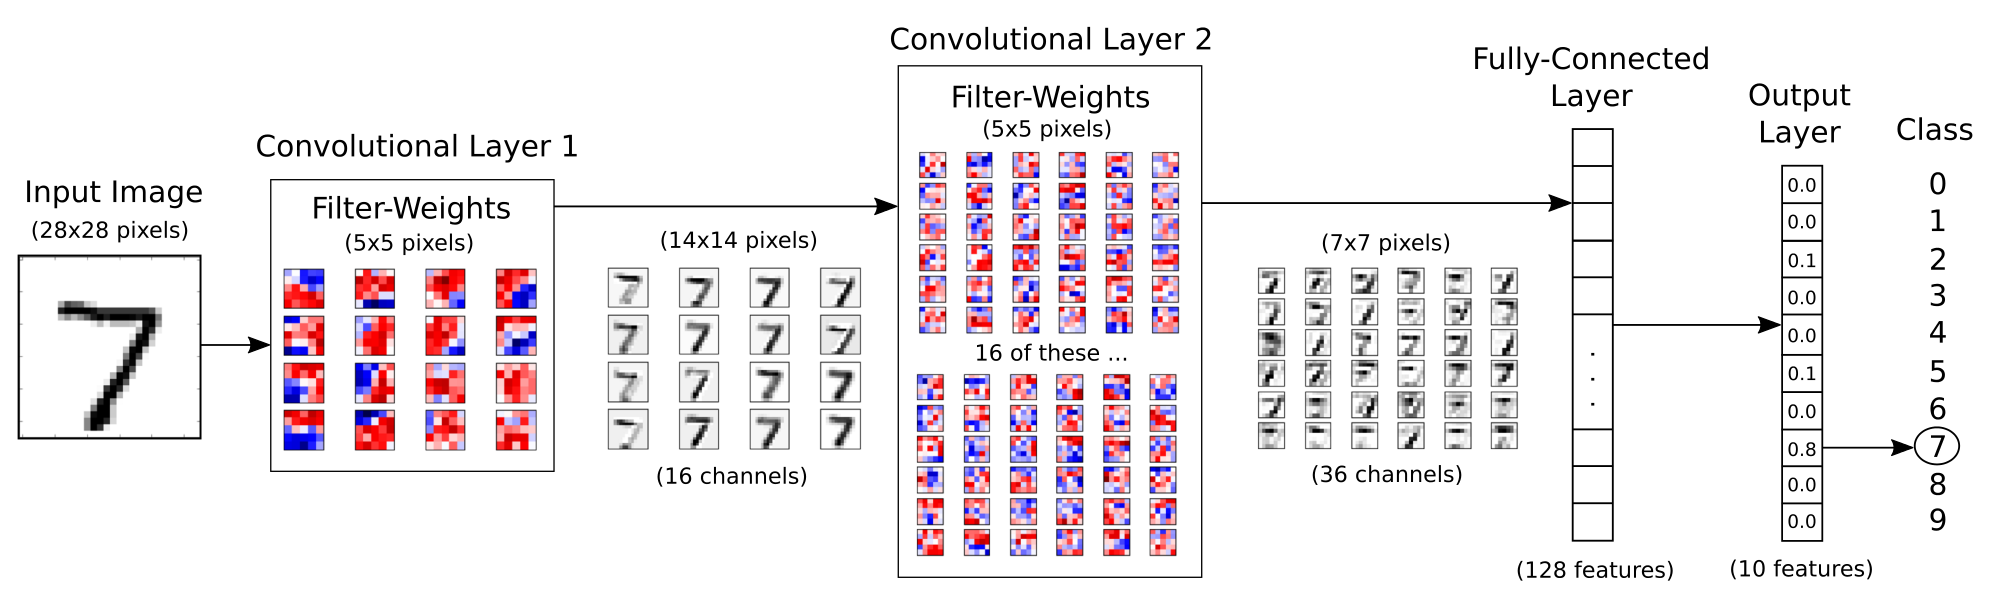

In [10]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

## Imports

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

이 문서는 Python 3.6.2 (Anaconda) 및 TensorFlow 버전을 사용하여 개발되었습니다.

In [12]:
tf.__version__

'1.4.0'

PrettyTensor version:

In [13]:
pt.__version__

'0.7.4'

## Load Data

MNIST 데이터 세트의 크기는 약 12MB이며 주어진 경로에 위치하지 않으면 자동으로 다운로드됩니다.

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터 세트는 현재 로드 되었으며 70.000개의 이미지 및 관련 라벨 (즉, 이미지의 분류)로 구성됩니다. 데이터 집합은 3개의 상호 배타적인 하위 집합으로 나뉩니다. 이 튜토리얼에서는 훈련 및 테스트 세트 만 사용합니다.

In [15]:
print("크기:")
print("- 훈련 세트:\t\t{}".format(len(data.train.labels)))
print("- 테스트 세트:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

크기:
- 훈련 세트:		55000
- 테스트 세트:		10000
- Validation-set:	5000


클래스 레이블은 One-Hot로 인코딩 됩니다. 즉, 각 레이블은 하나의 요소를 제외하고 모두 0 인 요소가 포함 된 10개의 벡터입니다. 이 요소의 색인은 클래스 번호, 즉 연관된 이미지에 표시된 숫자입니다. 테스트 집합에 대한 클래스 수를 정수로 필요로 하므로 지금 계산합니다.

In [16]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

## Data Dimensions

데이터 차원은 아래 소스 코드의 여러 위치에서 사용됩니다. 그것들은 한 번 정의되어 있으므로 아래의 소스 코드에서 숫자 대신 이러한 변수를 사용할 수 있습니다.

In [17]:
# MNIST 데이터는 이미지의 한 변이 28 픽셀입니다.
img_size = 28

# 이미지는 각 변의 크기를 곱한 수의 일차원 배열로 표현이 됩니다.
img_size_flat = img_size * img_size

# 높이와 넓이로 구성된 튜플은 이미지를 재구성하기 위해서 필요합니다.
img_shape = (img_size, img_size)

# 이미지의 컬러 채널의 수: 1 그레이 스케일 이미지의 경우 1
num_channels = 1

# 클래스의 수, 클래스는 0~9까지의 숫자를 의미합니다.
num_classes = 10

### 이미지를 그리는 도움 함수

3x3그리드에 9개의 이미지를 플롯하고 각 이미지 아래에 참 및 예측 클래스를 쓰는 데 사용되는 함수입니다.

In [18]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 일부의 이미지를 그려서 데이터가 정확한지 확인해 봅니다.¶

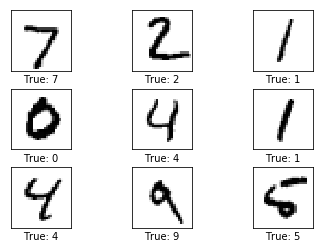

In [19]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

TensorFlow의 목적은 동일한 계산이 파이썬에서 직접 수행되는 것보다 훨씬 효율적으로 실행될 수있는 소위 연산 그래프를 구성하는 것입니다. TensorFlow는 실행해야 하는 전체 연산 그래프를 알고 있기 때문에 NumPy보다 더 효율적입니다. NumPy는 한 번에 하나의 수학 연산 만 계산합니다.

또한 TensorFlow는 그래프의 변수를 최적화하여 모델의 성능을 향상시키는 데 필요한 그래디언트를 자동으로 계산할 수 있습니다. 이것은 그래프가 간단한 수학적 표현의 조합이기 때문에 전체 그래프의 그래디언트가 미분에 대한 체인 규칙을 사용하여 계산 될 수 있기 때문입니다.

TensorFlow는 GPU뿐 아니라 멀티 코어 CPU를 활용할 수도 있습니다. Google은 TPU (Tensor Processing Units)라고 불리는 TensorFlow 용 특수 칩을 구축했으며 GPU보다 훨씬 빠릅니다.

TensorFlow 그래프는 아래에 설명 된 다음 부분으로 구성됩니다.

* Placeholder 변수: 변경되는 값을 입력으로 사용할 수 있도록 합니다.
* 모델 변수: 모델이 더 좋은 성능을 내도록 최적화 할 수 있습니다.
* 모델은 본질적으로 Placeholder 변수와 모델 변수의 입력이 제공되면 출력을 계산하는 수학 함수입니다.
* 비용: 변수들을 최적화 하기 위해서 사용되는 측정값 입니다.
* 최적화 기법: 모델의 변수를 변경합니다.

또한 TensorFlow 그래프는 다양한 디버깅 문을 포함 할 수 있습니다. 이 노트북에서는 다루지 않지만 TensorBoard를 사용하여 데이터를 표시하도록 로깅합니다.

### Placeholder 변수

Placeholder 변수는 그래프를 실행할 때마다 변경할 수 있는 TensorFlow 계산 그래프의 입력 값 역할을 합니다.

먼저 입력 이미지의 placeholder 변수를 정의합니다. 이를 통해 TensorFlow 그래프에 입력되는 이미지를 변경할 수 있습니다. 이것은 소위 텐서 (tensor)라고 불리는데, 이는 그것이 다차원 벡터 또는 행렬이라는 것을 의미합니다. 데이터 형은 `float32`로 설정되고 형태는 `[None, img_size_flat]`으로 설정됩니다. 여기서 `None`은 텐서가 임의의 수의 이미지를 보유 할 수 있음을 의미합니다. 각 이미지는 길이가 `img_size_flat`인 벡터입니다.

In [20]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

콘볼루션 레이어는 `x`가 4 차원 텐서로 인코딩 될 것으로 요구하므로 모양을 바꿔야 합니다. 요구되는 형태는 `[num_images, img_height, img_width, num_channels]`이 됩니다. 첫 번째 차원은 -1을 사용하여 자동으로 추론 할 수 있습니다. 따라서 재구성 작업은 다음과 같습니다.

In [21]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

다음으로 우리는 placeholder `x`에 입력 된 이미지와 관련된 실제 레이블에 대한 placeholder 변수를 갖습니다. 이 placeholder 변수의 모양은`[None, num_classes]`입니다. 이는 임의의 수의 레이블을 보유 할 수 있음을 의미하며 각 레이블은 이 경우에는 길이가 num_classes 인 벡터입니다.

In [22]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

클래스 번호에 대한 placeholder 변수를 사용할 수도 있지만 대신 argmax를 사용하여 이를 계산합니다. 이 값은 TensorFlow 연산자이므로 이 시점에서는 아무 것도 계산되지 않습니다.

In [23]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### 신경망 (Neural Network)

이 섹션에서는 Pretty Tensor를 사용하여 컨볼루션 신경망을 구현합니다. TensorFlow로 직접 구현하는 것 보다 훨씬 간단합니다 (튜토리얼 #03 참조).

기본 개념은 전체 신경망을 생성하기 위해 새로운 계산 계층을 추가하는 도움 함수가 있는 Pretty Tensor 객체로 입력 텐서 `x_image`를 감싸는 것 입니다.
Pretty Tensor는 변수 할당 등을 담당합니다.

In [24]:
x_pretty = pt.wrap(x_image)

Pretty Tensor 객체로 입력 이미지를 감싸게 했으므로 이제는 몇 줄의 소스 코드에 컨볼루션 및 완전 연결 레이어를 추가 할 수 있습니다.

`pt.defaults_scope (activation_fn = tf.nn.relu)`는 `with`블록 안에 구성된 각 레이어에 대해 `activation_fn = tf.nn.relu`를 인자로 만들어서 ReLU (Rectified Linear Units)를 층들 각각에 사용하도록 합니다. `defaults_scope`는 모든 레이어의 인자를 쉽게 바꿀 수있게합니다.

In [25]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### 가중치 구하기

아래에서 우리는 신경망의 가중치를 그래프로 나타내려고합니다. Pretty Tensor를 사용하여 네트워크를 구성하면 Pretty Tensor가 간접적으로 모든 변수를 만듭니다. 따라서 TensorFlow에서 변수를 검색해야 합니다.

우리는 두 개의 컨볼루션 레이어에 `layer_conv1`과 `layer_conv2`라는 이름을 사용했습니다. 이것들은 변수 범위(variable scope)라고도 불립니다 (위에서 설명 한 `defaults_scope`와 혼동해서는 안됩니다). Pretty Tensor는 각 레이어에 대해 만드는 변수에 이름을 자동으로 부여하므로 레이어의 범위 이름과 변수 이름을 사용하여 레이어의 가중치를 검색 할 수 있습니다.

실제 구현은 다른 목적을 위해 설계된 TensorFlow 함수 `get_variable()`을 사용하거나 새 변수를 만들거나 기존 변수를 다시 사용해야 하기 때문에 다소 어색해 질 수 있습니다. 가장 쉬운 방법은 다음과 같은 도움 함수를 만드는 것 입니다.

In [26]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

이 도움 함수를 사용하면 변수를 검색 할 수 있습니다. 검색된 변수는 모두 TensorFlow 개체입니다. 변수의 내용을 얻으려면 아래에서 더 자세히 설명하는 것 처럼 `content = session.run (weights_conv1)`과 같은 것을 실행해야 합니다.

In [27]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### 최적화 방법

Pretty Tensor는 신경망에서 입력 이미지를 분류하는 능력을 향상시키기 위해 예상되는 클래스 레이블 (`y_pred`)과 손실 측정을 최소화 해야 했습니다.

Pretty Tensor의 문서에서 분실 대책이 교차 엔트로피인지 또는 다른 것이 있는지는 분명하지 않습니다. 그러나 우리는 이제 손실을 최소화하기 위해`AdamOptimizer`를 사용합니다.

이 시점에서 최적화는 수행되지 않습니다. 사실, 아무것도 계산되지 않습니다. 나중에 실행을 위해 TensorFlow 그래프에 옵티 마이저 개체를 추가하기 만하면됩니다.

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### 성능 측정

사용자에게 진행 상황을 표시하기 위해 몇 가지 성능 측정 방법이 필요합니다.

먼저 우리는 10 개의 요소를 가진 벡터 인 `y_pred` 신경망의 출력으로부터 예측 된 클래스 번호를 계산합니다. 클래스 번호는 가장 큰 값을 가진 항목의 색인입니다.

In [29]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

그런 다음 예측 된 클래스가 각 이미지의 실제 클래스와 같은지 여부를 알려주는 부울 값의 벡터를 만듭니다.

In [30]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

부울 값의 벡터를 float 형으로 형변환하여 False가 0이되고 True가 1이되도록 분류 정확도를 계산 한 다음 이 수의 평균을 계산합니다.

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

신경망의 변수를 저장하기 위해 이제는 TensorFlow 그래프의 모든 변수를 저장하고 검색하는 데 사용되는 Saver라는 개체를 만듭니다. 이 시점에서 아무 것도 실제로 저장되지는 않습니다. `optimize()` 함수에서 더 아래에 실행 될 것입니다.

In [32]:
saver = tf.train.Saver()

저장된 파일은 최적화 중에 규칙적인 간격으로 기록 될 수 있기 때문에 종종 체크 포인트라고도 합니다.

아래의 디렉토리는 데이터 저장 및 검색에 사용되는 디렉토리입니다.

In [33]:
save_dir = 'checkpoints/'

디렉토리가 없으면 만듭니다.

In [34]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

이것은 체크포인트 파일의 경로입니다.

In [35]:
save_path = os.path.join(save_dir, 'best_validation')

## TensorFlow 실행

### TensorFlow session 만들기

TensorFlow 그래프가 생성되면 그래프를 실행하는 데 사용되는 TensorFlow 세션을 만들어야 합니다.

In [36]:
session = tf.Session()

### 변수 초기화

`weights`와`biases`등의 변수는 최적화를 시작하기 전에 초기화되어야합니다. 여러본 호출하기 때문에 간단한 래퍼 함수를 만듭니다.

In [37]:
def init_variables():
    session.run(tf.global_variables_initializer())

변수를 초기화하기 위해 지금 함수를 실행합니다.

In [38]:
init_variables()

### 최적화 반복을 수행하는 도움 함수

트레이닝 세트에는 55,000 개의 이미지가 있습니다. 이 모든 이미지를 사용하여 모델의 그래디언트를 계산하는 것은 시간이 꽤 오래 걸립니다. 따라서 우리는 옵티 마이저의 각 반복에서 작은 배치 이미지만 사용합니다.

메모리가 부족하여 컴퓨터가 다운되거나 충돌이 발생하면, 이 수를 줄이거 나 늘릴 수 있지만 더 많은 최적화 반복을 수행해야 할 수 있습니다.

In [39]:
train_batch_size = 64

점진적으로 네트워크 계층의 변수를 향상시키기 위해 최적화 반복을 수행하는 기능. 각 반복에서 훈련 세트에서 새로운 데이터 배치를 선택한 다음 TensorFlow는 이러한 훈련 샘플을 사용하여 최적화 프로그램을 실행합니다. 진행률은 매 100 회 반복됩니다.
유효성 검사의 정확성이 1000번 반복이후 개선되지 않으면 최적화가 중단됩니다. 이를 추적하기 위해서는 몇 가지 변수가 필요합니다.

In [40]:
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1000

점진적으로 네트워크 계층의 변수를 향상시키기 위해 최적화 최적화를 여러 번 수행하는 기능입니다. 각 반복에서 훈련 세트에서 새로운 데이터 배치를 선택한 다음 TensorFlow는 이러한 훈련 샘플을 사용하여 최적화를 실행합니다. 100회 반복마다 진행률이 인쇄되어 유효성 검사 정확도도 계산되고 개선 된 경우 파일에 저장됩니다.

In [41]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variables rather than local copies.
    global total_iterations
    global best_validation_accuracy
    global last_improvement

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Increase the total number of iterations performed.
        # It is easier to update it in each iteration because
        # we need this number several times in the following.
        total_iterations += 1

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if (total_iterations % 100 == 0) or (i == (num_iterations - 1)):

            # Calculate the accuracy on the training-batch.
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)

            # Calculate the accuracy on the validation-set.
            # The function returns 2 values but we only need the first.
            acc_validation, _ = validation_accuracy()

            # If validation accuracy is an improvement over best-known.
            if acc_validation > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = acc_validation
                
                # Set the iteration for the last improvement to current.
                last_improvement = total_iterations

                # Save all variables of the TensorFlow graph to file.
                saver.save(sess=session, save_path=save_path)

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''
            
            # Status-message for printing.
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3}"

            # Print it.
            print(msg.format(i + 1, acc_train, acc_validation, improved_str))

        # If no improvement found in the required number of iterations.
        if total_iterations - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")

            # Break out from the for-loop.
            break

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 분류 오류 이미지의 예를 표시하는 도움 함수

잘못 분류 된 테스트 세트의 이미지 예제를 출력하는 함수

In [42]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 혼란 행렬(Confusion matrix)을 그리기위한 도움 함수

In [43]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 분류 계산을위한 도움 함수

이 함수는 예측 된 이미지 클래스를 계산하고 각 이미지의 분류가 올바른지 여부를 불린 배열 형태로 반환합니다.

계산은 배치 형태로 수행하고, 그렇지 않으면 너무 많은 RAM을 사용하게 됩니다. 프로그램이 중단되는 경우, 배치 크기를 줄여보십시오.

In [44]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

테스트 세트에 대한 예상 클래스를 계산합니다.

In [45]:
def predict_cls_test():
    return predict_cls(images = data.test.images,
                       labels = data.test.labels,
                       cls_true = data.test.cls)

유효성 검사 집합(Validation Set)에 대한 예측 클래스를 계산합니다.

In [46]:
def predict_cls_validation():
    return predict_cls(images = data.validation.images,
                       labels = data.validation.labels,
                       cls_true = data.validation.cls)

### 분류 정확도를위한 도움 함수

이 함수는 부울 배열에 주어진 분류 정확도를 계산하여 각 이미지가 정확하게 분류되었는지 여부를 계산합니다. 예: `cls_accuracy ([True, True, False, False, False]) = 2/5 = 0.4`

In [47]:
def cls_accuracy(correct):
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(correct)

    return acc, correct_sum

유효성 검사 집합에 대한 정확도를 계산합니다.

In [48]:
def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    # The function returns two values but we only need the first.
    correct, _ = predict_cls_validation()
    
    # Calculate the classification accuracy and return it.
    return cls_accuracy(correct)

### 성능을 표시하는 도움 함수

테스트 세트에 대한 분류 정확도를 출력하는 함수입니다.

테스트 세트의 모든 이미지에 대한 분류를 계산하는 데 시간이 걸리기 때문에, 이 함수에서 위의 함수를 직접 호출하여 결과를 다시 사용하므로 각 함수에서 분류를 다시 계산할 필요가 없습니다.

In [49]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()

    # Classification accuracy and the number of correct classifications.
    acc, num_correct = cls_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### 컨볼루션 레이어의 가중치를 시각화 하기 위한 도움 함수

In [50]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print mean and standard deviation.
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 최적화 전 성능

모델 변수가 초기화되고 전혀 최적화되지 않았기 때문에 테스트 세트의 정확도는 매우 낮으므로 이미지를 무작위로 분류합니다.

In [51]:
print_test_accuracy()

Accuracy on Test-Set: 7.8% (780 / 10000)


컨볼 루션 가중치는 무작위이지만 아래에 표시된 최적화 된 가중치와의 차이점을 확인하기가 어려울 수 있습니다. 평균과 표준 편차가 표시되므로 차이가 있는지 확인할 수 있습니다.

Mean: -0.01354, Stdev: 0.29200


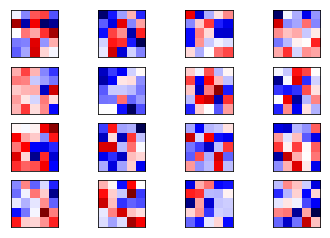

In [52]:
plot_conv_weights(weights=weights_conv1)

## 10,000번의 최적화 반복 수행

이제 10,000 개의 최적화 반복을 수행하고 1,000 번의 반복으로 유효성 검사 세트에 대한 성능이 개선되지 않으면 최적화를 중단합니다.

유효성 검증 세트의 분류 정확도가 개선 된 경우 별표*가 표시됩니다.

In [53]:
optimize(num_iterations=10000)

Iter:    100, Train-Batch Accuracy:  85.9%, Validation Acc:  85.2% *
Iter:    200, Train-Batch Accuracy:  84.4%, Validation Acc:  91.5% *
Iter:    300, Train-Batch Accuracy:  93.8%, Validation Acc:  93.4% *
Iter:    400, Train-Batch Accuracy:  95.3%, Validation Acc:  94.3% *
Iter:    500, Train-Batch Accuracy:  95.3%, Validation Acc:  95.1% *
Iter:    600, Train-Batch Accuracy: 100.0%, Validation Acc:  94.8% 
Iter:    700, Train-Batch Accuracy:  96.9%, Validation Acc:  95.8% *
Iter:    800, Train-Batch Accuracy:  93.8%, Validation Acc:  96.4% *
Iter:    900, Train-Batch Accuracy:  96.9%, Validation Acc:  96.5% *
Iter:   1000, Train-Batch Accuracy: 100.0%, Validation Acc:  96.4% 
Iter:   1100, Train-Batch Accuracy:  98.4%, Validation Acc:  96.3% 
Iter:   1200, Train-Batch Accuracy:  93.8%, Validation Acc:  96.5% *
Iter:   1300, Train-Batch Accuracy:  98.4%, Validation Acc:  97.5% *
Iter:   1400, Train-Batch Accuracy: 100.0%, Validation Acc:  97.4% 
Iter:   1500, Train-Batch Accuracy:  9

Accuracy on Test-Set: 99.0% (9898 / 10000)
Example errors:


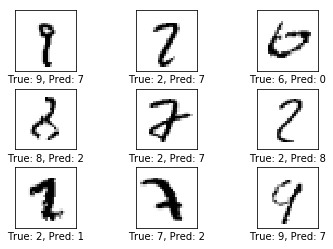

Confusion Matrix:
[[ 973    0    1    0    0    1    3    1    1    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   2    4 1018    0    1    0    0    4    2    1]
 [   0    0    1 1001    0    4    0    1    3    0]
 [   0    0    0    0  976    0    2    0    1    3]
 [   2    0    0    2    0  885    2    0    0    1]
 [   3    2    0    0    1    8  943    0    1    0]
 [   0    1    5    0    0    0    0 1022    0    0]
 [   2    0    2    2    1    0    0    2  962    3]
 [   0    4    0    1    5    4    0    9    2  984]]


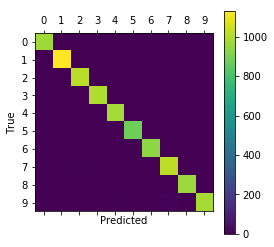

In [54]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

컨볼루션 가중치가 이제 최적화되었습니다. 위의 임의의 가중치와 비교하십시오. 그들은 거의 동일하게 보입니다. 사실, 처음에 저는 최적화 전후가 동일하게 보여서 프로그램 오류라고 생각했습니다.

그러나 이미지를 저장하고 비교하여 나란히 비교하십시오 (이미지를 마우스 오른쪽 버튼으로 클릭하여 이미지를 저장할 수 있음). 최적화 전과 후에 매우 작은 차이점을 알 수 있습니다.

평균 및 표준 편차도 약간 변경되었으므로 최적화 된 가중치가 달라야합니다.

Mean: 0.01641, Stdev: 0.30954


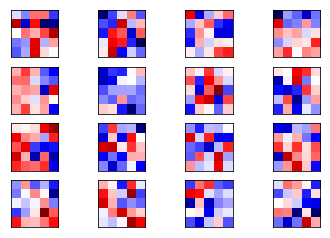

In [55]:
plot_conv_weights(weights=weights_conv1)

## 다시 변수를 초기화

신경망의 모든 변수를 임의의 값으로 다시 초기화 합니다.

In [56]:
init_variables()

이것은 신경망이 이미지를 완전히 무작위로 분류한다는 것을 의미하므로 분류 정확도는 무작위 추측과 같기 때문에 매우 열악합니다.

In [57]:
print_test_accuracy()

Accuracy on Test-Set: 9.3% (935 / 10000)


컨벌루션 가중치는 이제 위의 가중치와 달라야합니다.

Mean: -0.01086, Stdev: 0.28023


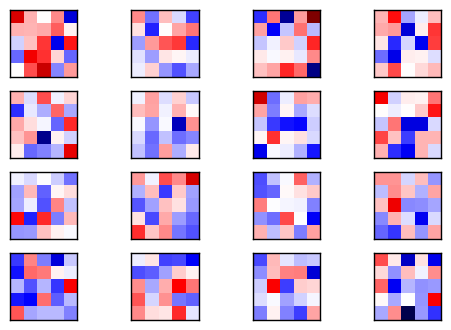

In [49]:
plot_conv_weights(weights=weights_conv1)

## 최적의 변수를 복원

최적화 중에 파일에 저장된 모든 변수를 다시로드 합니다.

In [50]:
saver.restore(sess=session, save_path=save_path)

이전에 저장된 변수를 사용할 때 분류 정확도가 다시 높아졌습니다.

파일의 변수가 유효성 검사 집합의 분류 정확도를 최대화하기 위해 선택 되었기 때문에 분류 정확도가 위에서 보고 된 것보다 약간 높거나 낮을 수 있지만 이러한 변수를 저장 한 후 최적화가 실제로 또 다른 1,000 반복 동안 계속되므로 우리는 두 개의 약간 다른 변수 세트에 대한 결과를 볼 수 있습니다. 때로는 테스트 세트에서 성능이 약간 더 좋거나 나빠질 수 있습니다.

Accuracy on Test-Set: 98.3% (9826 / 10000)
Example errors:


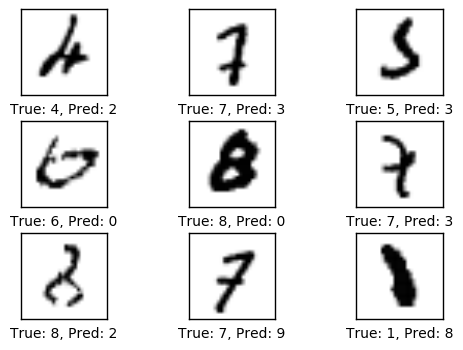

Confusion Matrix:
[[ 973    0    0    0    0    0    2    0    3    2]
 [   0 1124    2    2    0    0    3    0    4    0]
 [   2    1 1027    0    0    0    0    1    1    0]
 [   0    0    1 1005    0    2    0    0    2    0]
 [   0    0    3    0  968    0    1    0    3    7]
 [   2    0    1    9    0  871    3    0    3    3]
 [   4    2    1    0    3    3  939    0    6    0]
 [   1    3   19   11    2    0    0  972    2   18]
 [   6    0    3    5    1    0    1    2  951    5]
 [   3    3    0    1    4    1    0    0    1  996]]


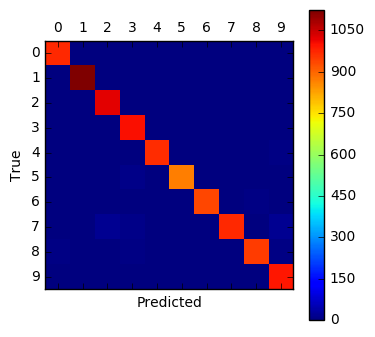

In [51]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

위의 가중치는 1,000 번의 최적화 반복이 있었으므로 완전히 동일하지는 않지만 컨볼루션 가중치는 위에 표시된 것과 거의 동일해야 합니다.

Mean: 0.02792, Stdev: 0.29822


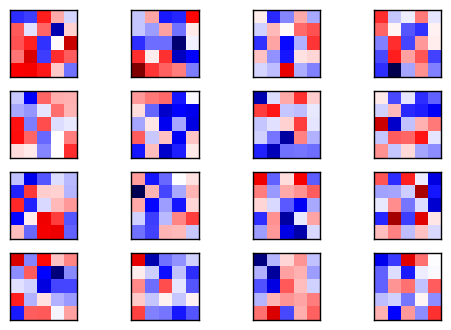

In [52]:
plot_conv_weights(weights=weights_conv1)

## TensorFlow Session 닫기

이제 TensorFlow를 사용하여 작업을 마쳤으므로 세션을 닫아 리소스를 해제합니다.

In [53]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## 결론

이 튜토리얼에서는 TensorFlow에서 신경망 변수를 저장하고 검색하는 방법을 보여줍니다. 이것은 다른 방식으로 사용될 수 있습니다. 예를 들어, 이미지를 인식하기 위해 신경망을 사용하려면 네트워크를 한 번만 교육하면 완료된 네트워크를 다른 컴퓨터에 배포 할 수 있습니다.

체크 포인트의 또 다른 용도는 신경망의 데이터 세트가 매우 큰 경우 컴퓨터가 중단 될 경우를 대비하여 정기적으로 체크 포인트를 저장하여 컴퓨터를 다시 시작하지 않고 최근 체크 포인트에서 최적화를 계속할 수 있도록하는 것입니다.

이 튜토리얼에서는 유효성 검증 오류를 장기적으로 개선되지 않는 경우 최적화를 중단 하는 소위 조기 정지 (Early Stopping)에 대해 유효성 검증 세트를 사용하는 방법도 설명했습니다. 이것은 신경망이 훈련 세트의 과도한 잡음을 배우기 시작하면 유용합니다. 이 튜토리얼에서 사용 된 컨볼루션 네트워크 및 MNIST 데이터 세트에는 실제로 문제가 되지 않았습니다.

관찰도중 흥미로운 점은 신경망의 성능이 임의의 추측에서 거의 완벽한 분류로 바뀌 었음에도 불구하고 컨벌루션 가중치 (또는 필터)가 최적화상태에서 극히 일부만 변경되었다는 것입니다. 랜덤 가중치가 거의 충분하다는 것이 이상하게 보입니다. 왜 그럴까요?

## 연습 문제

TensorFlow활용 기술을 향상 시키는데 도움이 될 수 있는 몇 가지 제안 사항입니다. TensorFlow를 제대로 사용하는 방법을 배우려면 실습 경험을 얻는 것이 중요합니다.

변경하기 전에 이 노트북을 백업 할 것을 권장합니다.

* 1000번의 반복 작업 후에도 성능이 개선이 안되면 최적화가 중단됩니다. 이것으로 충분한가요? Early Stopping을 하는 더 좋은 방법을 생각해 볼 수 있습니까? 시도하고 구현하십시오.
* 체크포인트 파일이 이미 있으면 최적화를 수행하는 대신 로드하십시오.
* 100번의 최적화 반복마다 새로운 체크 포인트를 저장하십시오. `saver.latest_checkpoint()`를 사용하여 최근 파일을 검색하십시오. 왜 가장 최근의 것보다 여러 개의 체크리스트를 저장하고 싶을까요?
* 신경망 구성을 바꿔보세요. 다른 레이어를 추가하고 다른 네트워크에서 저장한 변수들을 읽어들이면 어떻게 됩니까?
* `plot_conv_weights()`함수를 사용하여 최적화 전후의 두번째 컨벌루션 레이어에 대한 가중치를 플롯합니다. 그들은 거의 동일합니까?
* 최적화 된 컨볼루션 가중치가 무작위 초기화와 거의 같은 이유는 무엇이라고 생각하십니까?
* 이 소스 코드를 너무 많이 보지 않고 직접 프로그램을 다시 제작하십시오.
* 프로그램이 어떻게 작동하는지 동료에게 설명하십시오.

## 라이센스 (MIT)

저작권 (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

사용, 복사, 수정, 병합 할 수있는 권한을 포함하되 이에 국한되지 않고 소프트웨어를 취급하기 위해이 소프트웨어 및 관련 문서 파일 (이하 "소프트웨어")의 사본을 얻는 모든 사람에게 사용 권한이 무료로 부여됩니다 다음 조건에 따라 소프트웨어의 사본을 게시, 배포, 재 라이센스 또는 판매 할 수 있고 소프트웨어를 제공받는 사람에게 허용 할 수 있습니다.

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야합니다.

소프트웨어는 상품성, 특정 목적에의 적합성 및 비 침해에 대한 보증을 포함하여 (단, 이에 한하지 않음) 묵시적이든 명시적이든 어떠한 종류의 보증없이 "있는 그대로"제공됩니다. 제작자 또는 저작권 보유자는 소프트웨어 또는 사용과 관련하여 발생했거나 또는 기타 행위로 인해 발생한 청구, 기타 책임에 대해 어떠한 경우에도 책임을지지 않습니다.